### Tic-Tac-Toe with Reinforcement Q-Learning 

Tic-tac-toe with a Q-learning agent, under 100 lines of code.  Notebook adapted from [Q-Learning Tic-Tac-Toe, Briefly](https://planspace.org/20191103-q_learning_tic_tac_toe_briefly/) by Aaron Schumacher.  The Q-learning component of this notebook utilizes the TensorFlow deep learning library.

In [3]:
import random
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

The board is represented with a matrix, where zero means empty:

In [4]:
def new_board(size):
    return np.zeros(shape=(size, size))

Moves are represented by their coordinates, like `[0, 0]` for the upper left:

In [5]:
def available_moves(board):
    return np.argwhere(board == 0)

The first player is `+1` and the second player is `-1`, so having three in a row means getting a row, column, or diagonal to sum to `+3` or `-3`, respectively.

In [6]:
def check_game_end(board):
    best = max(list(board.sum(axis=0)) +    # columns
               list(board.sum(axis=1)) +    # rows
               [board.trace()] +            # main diagonal
               [np.fliplr(board).trace()],  # other diagonal
               key=abs)
    if abs(best) == board.shape[0]:  # assumes square board
        return np.sign(best)  # winning player, +1 or -1
    if available_moves(board).size == 0:
        return 0  # a draw (otherwise, return None by default)

Q-learning will require some state, so a player will be an object with a `move` method that takes a board and returns the coordinates of the chosen move. 

In [7]:
class Player():
    def new_game(self):
        pass
    def reward(self, value):
        pass

class RandomPlayer(Player):
    def move(self, board):
        return random.choice(available_moves(board))

Game loop, starting from any initial board:

In [8]:
def play(board, player_objs):
    for player in [+1, -1]:
        player_objs[player].new_game()
    player = +1
    game_end = check_game_end(board)
    while game_end is None:
        move = player_objs[player].move(board)
        board[tuple(move)] = player
        game_end = check_game_end(board)
        player *= -1  # switch players
    for player in [+1, -1]:
        reward_value = +1 if player == game_end else -1
        player_objs[player].reward(reward_value)
    return game_end

Play out a game between two random players and give the result:

In [ ]:
play(new_board(3), {+1: RandomPlayer(), -1: RandomPlayer()})

Play out 10,000 games between two random players:

In [9]:
# 3x3, random vs. random
random.seed(1)
results = [play(new_board(3), {+1: RandomPlayer(), -1: RandomPlayer()}) for _ in range(10000)]
collections.Counter(results)

Counter({1.0: 5878, -1.0: 2900, 0: 1222})

In [10]:
def moving(data, value=+1, size=100):
    binary_data = [x == value for x in data]
    # this is wasteful but easy to write...
    return [sum(binary_data[i-size:i])/size for i in range(size, len(data) + 1)]

def show(results, size=500, title='Moving average of game outcomes',
         first_label='First Player Wins', second_label='Second Player Wins', draw_label='Draw'):
    x_values = range(size, len(results) + 1)
    first = moving(results, value=+1, size=size)
    second = moving(results, value=-1, size=size)
    draw = moving(results, value=0, size=size)
    first, = plt.plot(x_values, first, color='red', label=first_label)
    second, = plt.plot(x_values, second, color='blue', label=second_label)
    draw, = plt.plot(x_values, draw, color='grey', label=draw_label)
    plt.xlim([0, len(results)])
    plt.ylim([0, 1])
    plt.title(title)
    plt.legend(handles=[first, second, draw], loc='best')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
    ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.ylabel(f'Rate over trailing window of {size} games')
    plt.xlabel('Game Number')
    plt.show()

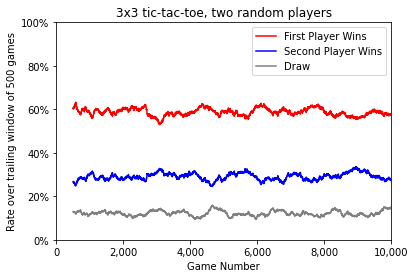

In [11]:
show(results, title='3x3 tic-tac-toe, two random players')

The "boring player" chooses the first available move from left to right, top to bottom:

In [12]:
class BoringPlayer(Player):
    def move(self, board):
        return available_moves(board)[0]

In [13]:
# 3x3, boring vs. random
random.seed(2)
results = [play(new_board(3), {+1: BoringPlayer(), -1: RandomPlayer()}) for _ in range(10000)]
collections.Counter(results)

Counter({1.0: 7790, -1.0: 1780, 0: 430})

In [14]:
# 3x3, random vs. boring
random.seed(3)
results = [play(new_board(3), {+1: RandomPlayer(), -1: BoringPlayer()}) for _ in range(10000)]
collections.Counter(results)

Counter({-1.0: 4444, 1.0: 5158, 0: 398})

The Q-learning player starts with a neural network that takes a board as input and produces an estimate of how good each move is from that position: Q-values.

In [15]:
class Agent(Player):
    def __init__(self, size, seed):
        self.size = size
        self.training = True
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(
            size**2,
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)))
        self.model.compile(optimizer='sgd', loss='mean_squared_error')

    def predict_q(self, board):
        return self.model.predict(
            np.array([board.ravel()])).reshape(self.size, self.size)

    def fit_q(self, board, q_values):
        self.model.fit(
            np.array([board.ravel()]), np.array([q_values.ravel()]), verbose=0)

    def new_game(self):
        self.last_move = None
        self.board_history = []
        self.q_history = []

    # The move method uses the Q-network to choose the best available move 
    # and then calls the reward method
    def move(self, board):
        # always ask the agent to play the same side
        q_values = self.predict_q(board)
        temp_q = q_values.copy()
        temp_q[board != 0] = temp_q.min() - 1  # no illegal moves
        move = np.unravel_index(np.argmax(temp_q), board.shape)
        value = temp_q.max()
        if self.training and self.last_move is not None:
            self.reward(value)
        self.board_history.append(board.copy())
        self.q_history.append(q_values)
        self.last_move = move
        return move

    # The reward method trains the Q-network, updating a previous estimate 
    # of Q-values with a new estimate for the last chosen move.
    def reward(self, reward_value):
        if not self.training:
            return
        new_q = self.q_history[-1].copy()
        new_q[self.last_move] = reward_value
        self.fit_q(self.board_history[-1], new_q)

Play out 10,000 games with Q-learning agent playing against a random agent.  The `play` function resets games and delivers a reward of `+1` for wins and `-1` for losses and draws.

**NOTE:** the cell below will take a long time (~50+ min) to compute!

In [16]:
# 3x3, q-learning vs. random
random.seed(4)
agent = Agent(3, seed=4)
results = [play(new_board(3), {+1: agent, -1: RandomPlayer()}) for _ in range(10000)]
collections.Counter(results)

Counter({1.0: 9006, -1.0: 805, 0: 189})

The visualization below shows that the Q-learning player quickly achieves much stronger play than the random player:

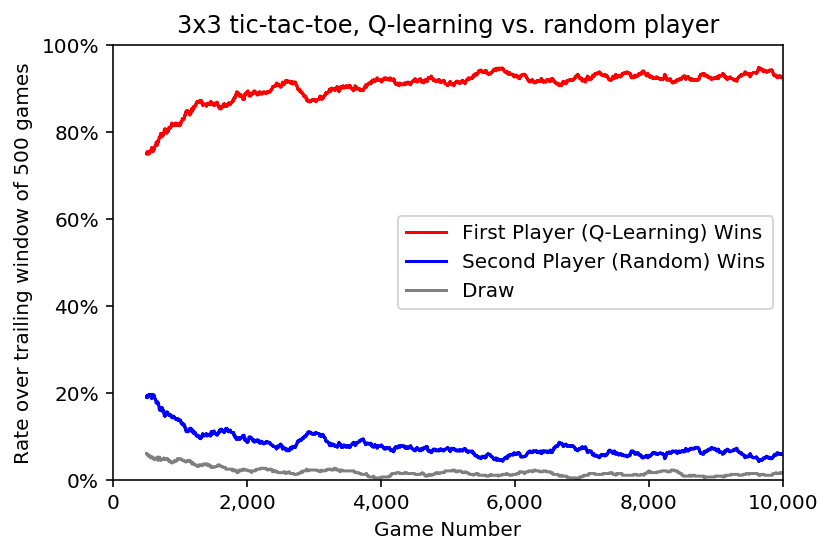

In [17]:
show(results, title='3x3 tic-tac-toe, Q-learning vs. random player',
     first_label='First Player (Q-Learning) Wins',
     second_label='Second Player (Random) Wins')